In [1]:
from imdb import IMDb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import time
import os
from pathlib import Path
from ipdb import set_trace
from itertools import combinations
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import time

pd.options.mode.chained_assignment = None

#### Data Acquisition and Setup

In [2]:
ids_with_posters = os.listdir('Multi_Label_dataset/Images')
ids_with_posters = [i[:i.rindex('.')] for i in ids_with_posters]
imdb_data = pd.read_csv('imdb_data.csv')
data = imdb_data.query('id in @ids_with_posters & type == "movie"')
data.dropna(axis=0)
data.sort_values('releaseYear', inplace=True)
data

,id,title,type,genres,averageRating,numVotes,releaseYear
4821,tt0010949,The Adventurer,movie,"Adventure, Drama, History",2.4,25.0,1920.0
4822,tt0010950,The Adventures of Bob and Bill,movie,Adventure,5.2,24.0,1920.0
4825,tt0010953,Algol: Tragedy of Power,movie,"Fantasy, Sci-Fi",6.3,293.0,1920.0
4826,tt0010954,Alias Jimmy Valentine,movie,"Crime, Drama",6.7,20.0,1920.0
4827,tt0010955,Alias Miss Dodd,movie,"Comedy, Mystery",NaN,NaN,1920.0
...,...,...,...,...,...,...,...
806465,tt4034452,Hyena Road,movie,"Action, Drama, War",6.5,9313.0,2015.0
675570,tt2848292,Pitch Perfect 2,movie,"Comedy, Music",6.4,172926.0,2015.0
806935,tt4046784,Maze Runner: The Scorch Trials,movie,"Action, Adventure, Sci-Fi",6.3,285627.0,2015.0
594823,tt2265431,Me You and Five Bucks,movie,"Comedy, Drama, Romance",4.5,130.0,2016.0


In [3]:
# A few movie posters don't have 3 color channels. Get rid of these to make the data set consistent.
# We only need to run this once after acquiring all our data.
run_this_cell = False
if run_this_cell:
    irregular_channels_ids = []
    for ind, movie_id in zip(data.index, data['id']):
        poster_path = Path(f'Multi_Label_dataset/Images/{movie_id}.jpg')
        poster = np.array(Image.open(poster_path))
        if poster.shape[-1] != 3:
            data.drop(ind, inplace=True)
            os.remove(poster_path)

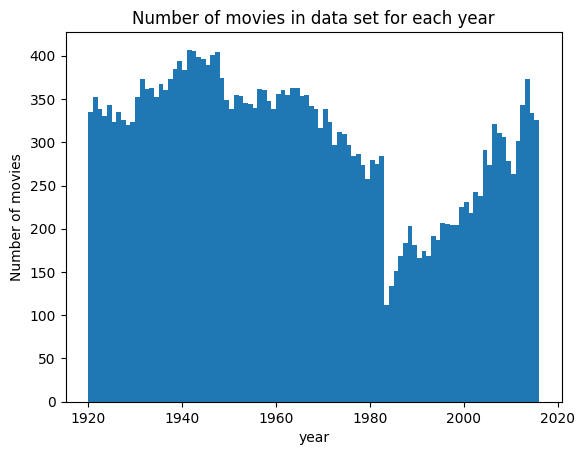

In [4]:
plt.hist(data['releaseYear'], bins=len(data['releaseYear'].unique())-1)
plt.gca().set(xlabel='year', ylabel='Number of movies', title='Number of movies in data set for each year')
plt.show()

In [5]:
run_this_cell = False # Only use this cell for dataset acquisition. Otherwise, turn it off so it doesn't accidentally get run.
if run_this_cell:
    ia = IMDb()
    for iter in range(212, 500):
        for year in np.arange(1920, 1983, dtype=float):
            data_year = imdb_data.query('releaseYear == @year')
            movie_id = data_year['id'].iloc[iter]
            try:
                movie = ia.get_movie(movie_id[2:])
                poster_url = movie.get('full-size cover url')
                response = requests.get(poster_url)
                img = Image.open(BytesIO(response.content))
                filename = f'Multi_Label_dataset/Images/{movie_id}.jpg'
                img.save(filename)
            except Exception:
                continue
        print(f'Completed iteration {iter}.')

In [6]:
def sample_movies_by_year(df, start_year, end_year, n, year_column='releaseYear'):
    filtered_df = df[(df[year_column] >= start_year) & (df[year_column] <= end_year)]
    sampled_df = (filtered_df.groupby(year_column, group_keys=False).apply(lambda group: group.sample(n=n, random_state=42)))
    return sampled_df.reset_index(drop=True)

In [10]:
data = data.query('releaseYear < 2016')

In [13]:
n = np.min(data.groupby('releaseYear').size())
sampled_data = sample_movies_by_year(data, 1920, 2015, n=n)
sampled_data_test = sample_movies_by_year(data, 1920, 2015, 2)

C:\Users\Rickr\AppData\Local\Temp\ipykernel_11024\7521350.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = (filtered_df.groupby(year_column, group_keys=False).apply(lambda group: group.sample(n=n, random_state=42)))
C:\Users\Rickr\AppData\Local\Temp\ipykernel_11024\7521350.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = (filtered_df.groupby(year_column, group_keys=False).app

In [14]:
sampled_data.shape

(10752, 7)

In [15]:
poster_dict = {}
for movie_id in sampled_data['id']:
    poster = np.array(Image.open(f'Multi_Label_dataset/Images/{movie_id}.jpg'))
    poster_dict[int(movie_id[2:])] = poster
assert len(poster_dict) == sampled_data.shape[0]

In [ ]:
def generate_id_pairs_by_year(df, id_column='id', year_column='releaseYear', downsample_freq=1001):
    year_to_ids = df.groupby(year_column)[id_column].apply(list).to_dict()
    year_combinations = list(combinations(year_to_ids.keys(), 2))
    pairs = []
    for year1, year2 in year_combinations:
        ids1 = year_to_ids[year1]
        ids2 = year_to_ids[year2]
        pairs.extend((int(id1[2:]), int(id2[2:])) for id1 in ids1 for id2 in ids2)
    pairs = np.array(pairs)
    np.random.shuffle(pairs)
    return pairs[::downsample_freq]

In [30]:
id_pairs = generate_id_pairs_by_year(sampled_data, downsample_freq=10001)
labels = np.random.randint(0, 2, len(id_pairs))
id_pairs[labels==0] = id_pairs[labels==0][:, ::-1]

In [31]:
id_pairs.shape

(5720, 2)

#### Model Training

In [32]:
class MoviePairDataset(Dataset):
    def __init__(self, pairs, labels, poster_dict, transform=None):
        """
        Args:
            pairs (list of tuples): List of movie ID pairs.
            labels (list): List of binary labels (0 or 1).
            poster_dict (dict): Dictionary where keys are movie IDs and values are poster images.
            transform (callable, optional): Transform to apply to the poster images.
        """
        self.pairs = pairs
        self.labels = labels
        self.poster_dict = poster_dict
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        id1, id2 = self.pairs[idx]
        label = self.labels[idx]

        poster1 = self.poster_dict[id1]
        poster2 = self.poster_dict[id2]

        if self.transform:
            poster1 = self.transform(poster1)
            poster2 = self.transform(poster2)

        return poster1, poster2, torch.tensor(label, dtype=torch.long)

In [33]:
class PosterComparisonModel(nn.Module):
    def __init__(self, feature_dim=512):
        super(PosterComparisonModel, self).__init__()
        resnet = models.resnet18(pretrained=True) # Pretrained feature extractor (ResNet)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1]) # Remove the last layer
        self.flatten = nn.Flatten()

        self.fc = nn.Sequential(
            nn.Linear(2 * feature_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, poster1, poster2):
        features1 = self.feature_extractor(poster1)
        features1 = self.flatten(features1)
        features2 = self.feature_extractor(poster2)
        features2 = self.flatten(features2)

        combined_features = torch.cat((features1, features2), dim=1)

        out = self.fc(combined_features)
        return out

In [34]:
train_pairs, temp_pairs, train_labels, temp_labels = train_test_split(id_pairs, labels, test_size=0.2, random_state=42, shuffle=True)
val_pairs, test_pairs, val_labels, test_labels = train_test_split(temp_pairs, temp_labels, test_size=0.5, random_state=42, shuffle=True)
del temp_pairs, temp_labels # Cover our bases for memory consumption here...

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = MoviePairDataset(pairs=train_pairs, labels=train_labels, poster_dict=poster_dict, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = MoviePairDataset(pairs=val_pairs, labels=val_labels, poster_dict=poster_dict, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = MoviePairDataset(pairs=test_pairs, labels=test_labels, poster_dict=poster_dict, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [35]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

143
18
18


In [41]:
# Training loop
def train_model(model, train_loader, optimizer, criterion, device, val_loader, print_freq=100, valid_freq=1000):
    model.train()
    model.to(device)
    total_loss = 0
    last_printout_time = time.time()
    loss_list, acc_list = [], []
    overall_loss_list, overall_acc_list = [], []
    for i, (poster1, poster2, labels) in enumerate(train_loader):
        poster1, poster2, labels = poster1.to(device), poster2.to(device), labels.to(device)

        # Forward pass
        outputs = model(poster1, poster2)
        loss = criterion(outputs, labels)

        # Backprop and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Get loss and accuracy metrics
        loss_item = loss.item()
        total_loss += loss_item
        loss_list.append(loss_item)
        overall_loss_list.append(loss_item)

        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        total = labels.size(0)
        accuracy = correct / total
        acc_list.append(accuracy)
        overall_acc_list.append(accuracy)

        # Occasionally print results
        if print_freq > 0 and i % print_freq == 0 and i != 0:
            print(f'Batch {i}: Loss: {loss.item():.2g}, Accuracy: {accuracy*100:.2f}%')
            print(f'Avg loss since last printout: {np.mean(loss_list):.2g}, Accuracy since last printout: {np.mean(acc_list)*100:.2f}%')
            print(f'Those {print_freq} batches took {time.time() - last_printout_time:.2f}s.')
            loss_list, acc_list = [], []
            last_printout_time = time.time()
            print('-'*100)

        # Occasionally validate
        if valid_freq > 0 and i % valid_freq == 0 and i != 0:
            print('Validating...')
            valid_acc = test_model(model, val_loader, device)
            print(f'Validation accuracy: {valid_acc}')

    return overall_loss_list, overall_acc_list

# Testing loop
def test_model(model, test_loader, device):
    model.eval()
    model.to(device)
    correct = 0
    total = 0
    accs = []

    with torch.no_grad():
        for poster1, poster2, labels in test_loader:
            poster1, poster2, labels = poster1.to(device), poster2.to(device), labels.to(device)

            # Forward pass
            outputs = model(poster1, poster2)
            _, predicted = torch.max(outputs, 1)

            accs.append((predicted == labels).sum() / labels.size(0))

    return accs

In [ ]:
# Initialize model, loss, and optimizer
model = PosterComparisonModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10

test_accs = []
train_batch_accs = []
train_batch_losses = []
test_batch_accs = []
for epoch in range(num_epochs):
    train_losses, train_accs = train_model(model, train_loader, optimizer, criterion, device, val_loader, print_freq=10, valid_freq=-1)
    test_accs = test_model(model, test_loader, device)
    train_batch_accs.extend(train_accs)
    train_batch_losses.extend(train_losses)
    test_batch_accs.extend(test_accs)

    print('-'*100)
    print(f"Epoch {epoch + 1}, Loss: {np.mean(train_losses):.4f}, Test Accuracy: {np.mean(test_accs):.4f}")
    print('-'*100)
    print('-'*100)

c:\Users\Rickr\miniconda3\envs\elec576_final_project_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Rickr\miniconda3\envs\elec576_final_project_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Batch 10: Loss: 0.45, Accuracy: 71.88%
Avg loss since last printout: 0.61, Accuracy since last printout: 63.07%
Those 10 batches took 73.68s.
----------------------------------------------------------------------------------------------------
Batch 20: Loss: 0.59, Accuracy: 71.88%
Avg loss since last printout: 0.58, Accuracy since last printout: 73.75%
Those 10 batches took 69.74s.
----------------------------------------------------------------------------------------------------
Batch 30: Loss: 0.46, Accuracy: 78.12%
Avg loss since last printout: 0.54, Accuracy since last printout: 74.06%
Those 10 batches took 70.04s.
----------------------------------------------------------------------------------------------------
Batch 40: Loss: 0.49, Accuracy: 71.88%
Avg loss since last printout: 0.53, Accuracy since last printout: 72.50%
Those 10 batches took 70.37s.
----------------------------------------------------------------------------------------------------
Batch 50: Loss: 0.45, Accura